In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import copy
import torch
import torch.nn as nn
import torch.optim as optim

class PMYojana():
    def __init__(self) -> None:
        self.DCR = 33e6 #DCR Program cost per MW
        self.NON_DCR = 26e6 #Non-DCR Program cost per MW
        self.INFLATION = 0.06 #Inflation Rate
        self.YOJANA_LENGTH = 25 #How long is the Yojana
        self.UNITS = 4500 #Units per MW
        self.LAND_INCREASE = 0.05 #how much it increases every two years

    def loan_amount(self, project_size: float, DCR_status: bool, loan_size: float, subsidy_size:float):
        '''
        If the loan_size is a percent, this function simply converts it to an amount.
        For example, if you type in loan_size = 70, this will calculate 70% of the project cost.
        '''
        if loan_size <= 100000:
            if DCR_status:
                return ((self.DCR * project_size - subsidy_size)) * (loan_size/100)
            else:
                return ((self.NON_DCR * project_size - subsidy_size)) * (loan_size/100)
        else:
            return loan_size


    def total_amount(self, bid_rate: float, project_size: float):
        '''
        The absolute return without any cost involved. Calculates the gross number.
        '''
        nominal_per_year = project_size * 4500 * 365 * bid_rate #Return in Rupees/per year
        total_return = [nominal_per_year] * self.YOJANA_LENGTH
        solar_breakdown = [1.0]*25
        solar_breakdown[0] = 0.98
        for i in range(1, len(solar_breakdown)):
            solar_breakdown[i] *= solar_breakdown[i-1]*0.994
        for j in range(len(total_return)):
            total_return[j] *= solar_breakdown[j]
        dictionary = {'Year': np.arange(1, 26), 'Gross Return': total_return}
        absolute_structure = pd.DataFrame.from_dict(dictionary)       

        return absolute_structure


    def emi_payment(self, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, bank_loan_rate = 0.105, DCR_status=True):
        '''
        EMI Payment structure for the specified length.
        '''
        structure = [0.0] * self.YOJANA_LENGTH

        #loan in percent
        loan_size = self.loan_amount(project_size=project_size, DCR_status=DCR_status, loan_size=loan_size, subsidy_size=subsidy_size)

        emi_amount = (loan_size * bank_loan_rate)/(1 - (1 + bank_loan_rate)**(-1*pay_emi_in))

        for i in range(pay_emi_in):
            structure[i] = emi_amount
        
        #Creating a dictionary for exit
        dictionary = {'Year': np.arange(1, 26), 'EMI': structure}
        emi_structure = pd.DataFrame.from_dict(dictionary)

        return emi_structure
    
    def nominal_amount(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size:float, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        '''
        Nominal amount = Total amount - EMI Payment
        '''
        total_amount = self.total_amount(bid_rate=bid_rate, project_size=project_size)
        emi_pay = self.emi_payment(project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, DCR_status=DCR_status)
        land_cost = self.land_cost(project_size=project_size, cost_per_bigha_per_month=cost_per_bigha_per_month)
        expense_cost = self.expenses(monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        nominal_amount = total_amount
        nominal_amount['Nominal Amount'] = total_amount['Gross Return'] - emi_pay['EMI'] - land_cost['Land Cost'] - expense_cost['Expense Cost']

        return nominal_amount[['Year', 'Nominal Amount']]
    
    def inflation_rate(self, ):
        '''
        Calculates the effects of inflation for 25Y.
        '''
        inflation_adjust = [1.0] * self.YOJANA_LENGTH
        for i in range(len(inflation_adjust)):
            inflation_adjust[i] *= (1 + self.INFLATION)**(i+1)

        dictionary = {'Year': np.arange(1, 26), 'Inflation': inflation_adjust}
        inflation_by_year = pd.DataFrame.from_dict(dictionary)

        return inflation_by_year
    
    def real_amount(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        '''
        Nominal amount realized by the inflation factor.
        '''
        #get Nominal Amounts
        nominal_amount = self.nominal_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, DCR_status=DCR_status, cost_per_bigha_per_month=cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        
        #turn it into Real Amounts
        real_amount = nominal_amount

        #inflation
        inflation = self.inflation_rate()

        real_amount['Real Amount'] = nominal_amount['Nominal Amount'] / inflation['Inflation']

        return real_amount[['Year', 'Real Amount']]
    
    def annualized_return(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        if realized:
            amount = self.real_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            overall_val = sum(amount['Real Amount'])
        else:
            amount = self.nominal_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month,monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            overall_val = sum(amount['Nominal Amount'])
        if DCR_status:
            overall_investment = (project_size * self.DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
            if realized:
                print(f'Realized return of {round(overall_val, 0)} INR on {round(overall_investment, 2)} investment.')
                print(f'{round((((overall_val/overall_investment)**(1/25))-1)*100, 2)}% return over {self.INFLATION*100}% inflation over {self.YOJANA_LENGTH} years.')
            else:
                print(f'Nominal return of {round(overall_val, 0)} INR on {round(overall_investment, 2)} investment.')
                print(f'{round((((overall_val/overall_investment)**(1/25))-1)*100, 2)}% return over {self.YOJANA_LENGTH} years.')
        else:
            overall_investment = (project_size * self.NON_DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
            if realized:
                print(f'Realized return of {round(overall_val, 0)} INR on {round(overall_investment, 2)} investment.')
                print(f'{round((((overall_val/overall_investment)**(1/25))-1)*100, 2)}% return over {self.INFLATION*100}% inflation over {self.YOJANA_LENGTH} years.')
            else:
                print(f'Nominal return of {round(overall_val, 0)} INR on {round(overall_investment, 2)} investment.')
                print(f'{round((((overall_val/overall_investment)**(1/25))-1)*100, 2)}% return over {self.YOJANA_LENGTH} years.')
            
        
        return 

    def figure_total(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        '''
        Draw total, nominal, and emi payments.
        '''
        emi_amount = self.emi_payment(project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in)
        nominal_amount = self.nominal_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        real_amount = self.real_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)

        plt.plot(emi_amount['Year'], emi_amount['EMI']/1e5)
        plt.plot(emi_amount['Year'], nominal_amount['Nominal Amount']/1e5)
        plt.plot(emi_amount['Year'], real_amount['Real Amount']/1e5)

        plt.scatter(emi_amount['Year'], emi_amount['EMI']/1e5)
        plt.scatter(emi_amount['Year'], nominal_amount['Nominal Amount']/1e5)
        plt.scatter(emi_amount['Year'], real_amount['Real Amount']/1e5)

        plt.legend(['EMI', 'Nominal Amount', 'Real Amount'])
        plt.xlabel('Year')
        plt.ylabel('In Lakhs')
        plt.grid(True)

        self.annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        return
    
    def _annualized_return(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized: bool, DCR_status: bool, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        if realized:
            amount = self.real_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            overall_val = sum(amount['Real Amount'])
        else:
            amount = self.nominal_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, pay_emi_in=pay_emi_in, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            overall_val = sum(amount['Nominal Amount'])
        if DCR_status:
            overall_investment = (project_size * self.DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
        else:
            overall_investment = (project_size * self.NON_DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
        
        return (((overall_val/overall_investment)**(1/25))-1)*100

    def _figure_return(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, compare: str, realized: bool, DCR_status: bool, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        if compare == 'bid_rate':
            if type(bid_rate) != list:
                x = np.linspace(0.5*bid_rate, 1.5*bid_rate, 10)
            else:
                x = np.linspace(bid_rate[0], bid_rate[-1], 10)
            #output
            y = []
            for val in x:
                y.append(self._annualized_return(bid_rate=val, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate))
            plt.plot(x, y)
            plt.scatter(x, y)
            plt.grid(True)
            plt.xlabel('Bid Rate')
            if realized:
                plt.ylabel(f'Realized Return over {round(self.INFLATION*100, 2)}% inflation')
            else:
                plt.ylabel('Nominal Return')
        elif compare == 'project_size':
            if type(project_size) != list:
                x = np.linspace(0.5*project_size, 1.5*project_size, 10)
            else:
                x = np.linspace(project_size[0], project_size[-1], 10)
            #output
            y = []
            for val in x:
                y.append(self._annualized_return(bid_rate=bid_rate, project_size=val, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate))
            plt.plot(x, y)
            plt.scatter(x, y)
            plt.grid(True)
            plt.xlabel('Project Size in MW')
            if realized:
                plt.ylabel(f'Realized Return over {round(self.INFLATION*100, 2)}% inflation')
            else:
                plt.ylabel('Nominal Return')
        elif compare == 'loan_size':
            if type(loan_size) != list:
                x = np.linspace(0.75*loan_size, 1.25*loan_size, 10)
            else:
                x = np.linspace(loan_size[0], loan_size[-1], 10)
            #output
            y = []
            for val in x:
                y.append(self._annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=val, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate))
            plt.plot(x, y)
            plt.scatter(x, y)
            plt.grid(True)
            plt.xlabel('Loan Amount')
            if realized:
                plt.ylabel(f'Realized Return over {round(self.INFLATION*100, 2)}% inflation')
            else:
                plt.ylabel('Nominal Return')
        elif compare == 'pay_emi_in':
            if type(pay_emi_in) != list:
                x = np.arange(int(0.5*pay_emi_in), min(int(1.5*pay_emi_in) + 1, 16), 1)
            else:
                x = np.arange(pay_emi_in[0], pay_emi_in[-1], 1)
            #output
            y = []
            for val in x:
                y.append(self._annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=val, subsidy_size=subsidy_size, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate))
            plt.plot(x, y)
            plt.scatter(x, y)
            plt.grid(True)
            plt.xlabel('EMI Duration')
            if realized:
                plt.ylabel(f'Realized Return over {round(self.INFLATION*100, 2)}% inflation')
            else:
                plt.ylabel('Nominal Return')
        elif compare == 'subsidy_size':
            if type(subsidy_size) != list:
                x = np.linspace(0.5*subsidy_size, 1.5*subsidy_size, 10)
            else:
                x = np.linspace(subsidy_size[0], subsidy_size[-1], 10)
            #output
            y = []
            for val in x:
                y.append(self._annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=val, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate))
            plt.plot(x, y)
            plt.scatter(x, y)
            plt.grid(True)
            plt.xlabel('Subsidy Size')
            if realized:
                plt.ylabel(f'Realized Return over {round(self.INFLATION*100, 2)}% inflation')
            else:
                plt.ylabel('Nominal Return')
        else:
            print('Error! Get better idiot (Check Spelling).')
        return
    
    def full_roi(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2, _output=False):
        real_amount = list(self.real_amount(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)['Real Amount'])
        if DCR_status:
            overall_investment = (project_size * self.DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
        else:
            overall_investment = (project_size * self.NON_DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
        print(f'Investment of {round(overall_investment, 0)} INR.')
        total_real_return = 0
        for i in range(len(real_amount)):
            total_real_return += real_amount[i]
            if total_real_return >= overall_investment:
                diff = overall_investment - (total_real_return - real_amount[i])
                ratio_to_add = diff/real_amount[i]
                year = i-1
                break
        if _output:
            return round(year+1+ratio_to_add, 1)
        else:
            print(f'{round(year+1+ratio_to_add, 1)} years to get a full ROI.')
        
        return

    def compare(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, compare: str, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        if compare == 'DCR_status':
            print('DCR Case')
            self.annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=True, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            print('-'*10)
            print('Non-DCR Case')
            self.annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=realized, DCR_status=False, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        elif compare == 'realized':
            print('Nominal Return')
            self.annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=False, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
            print('-'*10)
            print('Realized Return')
            self.annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=True, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        else:
            self._figure_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, compare=compare, realized=realized, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)
        return
    def _overall_investment(self, project_size: float, loan_size: float, subsidy_size: float, DCR_status=True):
        if DCR_status:
            return (project_size * self.DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
        else:
            return (project_size * self.NON_DCR) - self.loan_amount(project_size=project_size, subsidy_size=subsidy_size, DCR_status=DCR_status, loan_size=loan_size) - subsidy_size
    
    def land_need(self, project_size: float):
        return 4.0*project_size #bighas of land
    
    def land_cost(self, project_size: float, cost_per_bigha_per_month = 3e4):
        total_land_cost = [cost_per_bigha_per_month] * self.YOJANA_LENGTH
        for i in range(0, len(total_land_cost), 2):
            total_land_cost[i] *= (1 + self.LAND_INCREASE)**(i//2)
            if i + 1 < len(total_land_cost):
                total_land_cost[i+1] *= (1 + self.LAND_INCREASE)**(i//2)

        dictionary = {'Year': np.arange(1, 26), 'Land Cost': total_land_cost}
        land_cost_by_year = pd.DataFrame.from_dict(dictionary)
        land_cost_by_year['Land Cost'] *= self.land_need(project_size=project_size)

        return land_cost_by_year
    
    def expenses(self, monthly_expenses=5e4, raise_rate=1/2):
        total_expenses = [monthly_expenses] * self.YOJANA_LENGTH 
        for i in range(len(total_expenses)):
            total_expenses[i] *= (1 + (self.INFLATION)*raise_rate)**(i)
        dictionary = {'Year': np.arange(1, 26), 'Expense Cost': total_expenses}
        total_expenses_by_year = pd.DataFrame.from_dict(dictionary)
        total_expenses_by_year['Expense Cost'] *= 12
        
        return total_expenses_by_year
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def softplus(self, x):
        return np.log(1 + np.exp(x))
    
    #def score(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2)
    

    def generate_latex_report(self, bid_rate: float, project_size: float, loan_size: float, pay_emi_in: int, subsidy_size: float, realized=True, DCR_status=True, cost_per_bigha_per_month = 3e4, monthly_expenses=5e4, raise_rate=1/2):
        # Generate image
        plt.figure(figsize=(15, 6))
        self.figure_total(bid_rate, project_size, loan_size, pay_emi_in, subsidy_size, realized, DCR_status)
        plt.savefig("figure_total.png")
        
        # Get full ROI
        full_roi_output = self.full_roi(bid_rate, project_size, loan_size, pay_emi_in, subsidy_size, realized, DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate, _output=True)
        overall_investment = self._overall_investment(project_size=project_size, loan_size=loan_size, subsidy_size=subsidy_size, DCR_status=DCR_status)
        # Add data to the table
        nominal_return = self.nominal_amount(bid_rate, project_size, loan_size, pay_emi_in, subsidy_size, DCR_status,cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)["Nominal Amount"]
        realized_return = self.real_amount(bid_rate, project_size, loan_size, pay_emi_in, subsidy_size, DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month, monthly_expenses=monthly_expenses, raise_rate=raise_rate)["Real Amount"]
        land_cost = self.land_cost(project_size=project_size, cost_per_bigha_per_month=cost_per_bigha_per_month)['Land Cost']
        land_needed = self.land_need(project_size=project_size)
        expense_cost = self.expenses(monthly_expenses=monthly_expenses, raise_rate=raise_rate)['Expense Cost']

        if DCR_status:
            DCR_Cost = self.DCR
        else:
            DCR_Cost = self.NON_DCR

        overall_nom = nominal_return.sum()
        overall_real = realized_return.sum()


        real_return = self._annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=True, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month)
        nom_return = self._annualized_return(bid_rate=bid_rate, project_size=project_size, loan_size=loan_size, pay_emi_in=pay_emi_in, subsidy_size=subsidy_size, realized=False, DCR_status=DCR_status, cost_per_bigha_per_month = cost_per_bigha_per_month)
        # LaTeX document content
        latex_content = f"""
        \\documentclass[10pt]{{article}}
        \\usepackage[left=0.5cm,right=0.5cm,top=0.5cm,bottom=0.5cm]{{geometry}}
        \\usepackage{{graphicx}}
        \\usepackage{{multirow}}
        \\usepackage{{multicol}}
        \\usepackage{{tfrupee}}
        \\begin{{document}}

        % Title
        \\title{{\\fontsize{{20}}{{24}}\\bfseries\\underline{{Solar Report}}}}
        \\author{{}}
        \\date{{}}
        \\maketitle
        \\vspace{{-0.5cm}} % Add some vertical space

        % Add line with project details
        \\vspace{{-1cm}}
        \\begin{{center}}
        \\textbf{{Bid Rate:}} \\rupee~{bid_rate}, \\textbf{{Project Size:}} {project_size}MW, \\textbf{{Loan Size:}} {loan_size}, \\textbf{{Subsidy Size:}} \\rupee~{subsidy_size}, \\textbf{{EMI Length:}} {pay_emi_in} years, \\textbf{{Land Needed:}} {land_needed} bighas, \\textbf{{Inflation:}} {round(self.INFLATION*100, 2)}\\%, \\textbf{{Salary Raise:}} {round(self.INFLATION*raise_rate*100, 2)}\\%, \\textbf{{DCR Cost:}} \\rupee~{round(DCR_Cost, 0)}/MW\\\\
        \\vspace{{-0.75cm}} % Add some vertical space
        \\end{{center}}


        % Include image
        \\begin{{figure}}[!htb]
        \\centering
        \\includegraphics[width=\\textwidth]{{figure_total.png}}
        \\caption{{Total Returns over 25 years}}
        \\end{{figure}}
        
        % Start multicol for table and full ROI output
        \\begin{{multicols}}{{2}}
        
        % Table
        \\begin{{tabular}}{{|c|c|c|c|c|}}
        \\hline
        Year & Nominal & Realized & Land & Expense\\\\
        \\hline
        """
        # Add data to the table
        for year, nominal, realized, land, expense in zip(range(1, len(nominal_return) + 1), nominal_return, realized_return, land_cost, expense_cost):
            latex_content += f"{year} & \\rupee~{nominal:.0f} & \\rupee~{realized:.0f} & \\rupee~{land:.0f} & \\rupee~{expense:.0f} \\\\ \n"

        # Complete LaTeX content for the table
        latex_content += """
        \\hline
        \\end{tabular}
        
        % End first column with a line
        \\columnbreak
        
        % Key Facts title
        \\textbf{\\textit{Key Facts}}:
        
        % Full ROI output as bullet point
        \\begin{itemize}
        """
        # Add full ROI output as a bullet point
        latex_content += f"\\item\\textbf{{Overall Investment}}: \\rupee~{round(overall_investment, 0)}"
        latex_content += f"\\item\\textbf{{Overall Nominal Return}}: \\rupee~{round(overall_nom, 0)}"
        latex_content += f"\\item\\textbf{{Overall Real Return}}: \\rupee~{round(overall_real, 0)} over {round(self.INFLATION*100, 2)}\\% inflation"
        latex_content += f"\\newline"
        latex_content += f"\\item\\textbf{{Nominal Returns}}: {round(nom_return, 2)}\\% returns over 25 years"
        latex_content += f"\\item\\textbf{{Real Returns}}: {round(real_return, 2)}\\% returns over {round(self.INFLATION*100, 2)}\\% inflation over 25 years"
        latex_content += f"\\newline"
        latex_content += f"\\item\\textbf{{Full ROI In}}: {round(full_roi_output, 1)} years"
        # End multicol
        latex_content += "\\end{itemize}\\end{multicols}"
        
        # Complete LaTeX content
        latex_content += "\\end{document}"

        # Write content to a .tex file
        with open("report.tex", "w") as f:
            f.write(latex_content)

        # Compile LaTeX to PDF
        subprocess.run(["pdflatex", "report.tex"])

        print("PDF report generated successfully.")

In [467]:
PMYojana()._annualized_return(bid_rate=3.19, project_size=3.2, loan_size=7e7, pay_emi_in=15, subsidy_size=1.07e7, realized=True, DCR_status=1)

5.307736840905064

In [77]:
#training phase
bid_rate_range = np.random.uniform(2.35, 3.65, (1000,))
project_size_range = np.random.uniform(1., 6.5, (1000,))
loan_size_range = np.random.uniform(60, 80, (1000,))
emi_size_range = np.random.choice([val for val in range(7, 16)], (1000,))
subsidy_size_range = np.random.uniform(25, 95, (1000,))
DCR_status_range = np.random.choice([0,1], 1000)


In [146]:
#pick up random cases
case_try = set()
for _ in range(50):
    case_try.add(np.random.randint(1, 1000))
len(case_try)

49

In [148]:
store = []

for val in case_try:
    subsidy_val = project_size_range[val] * (subsidy_size_range[val]/100) * 1e7
    investment = PMYojana()._overall_investment(project_size=project_size_range[val], loan_size=loan_size_range[val], subsidy_size=subsidy_val, DCR_status=DCR_status_range[val])
    realized_return = PMYojana().real_amount(bid_rate=bid_rate_range[val], project_size=project_size_range[val], loan_size=loan_size_range[val], pay_emi_in=emi_size_range[val], subsidy_size=subsidy_val, DCR_status=DCR_status_range[val])['Real Amount'].sum()
    ret = PMYojana()._annualized_return(bid_rate=bid_rate_range[val], project_size=project_size_range[val], loan_size=loan_size_range[val], pay_emi_in=emi_size_range[val], subsidy_size=subsidy_val, realized=True, DCR_status=DCR_status_range[val])
    inst = [bid_rate_range[val], project_size_range[val], loan_size_range[val], emi_size_range[val], subsidy_val, DCR_status_range[val]]
    try:
        print(f'Initial Investment: {investment} | Net Realized Returns: {realized_return} | Realized Return: {ret} | Sigmoid: {PMYojana().sigmoid((ret - 5))}')
        estimation = int(input('What do your rate it at:'))
        inst.append(estimation)
        store.append(copy.deepcopy(inst))
        print(f'You valued this at {estimation}/100')
    except:
        continue

Initial Investment: 33456069.662853926 | Net Realized Returns: 292119712.4460376 | Realized Return: 8.424919856898839 | Sigmoid: 0.968474330424591
You valued this at 95/100
Initial Investment: 28311233.68449273 | Net Realized Returns: 135319915.39774323 | Realized Return: 5.696162428205476 | Sigmoid: 0.6673363846306806
You valued this at 75/100
Initial Investment: 20546474.08258765 | Net Realized Returns: 99530424.68181868 | Realized Return: 5.290395452647023 | Sigmoid: 0.5720929435293952
You valued this at -100/100
Initial Investment: 33285961.745233245 | Net Realized Returns: 188301789.3721826 | Realized Return: 6.538515232216913 | Sigmoid: 0.8232487800073183
You valued this at 85/100
Initial Investment: 18805779.994350795 | Net Realized Returns: 98227021.59318566 | Realized Return: 6.260855671788934 | Sigmoid: 0.7791733717442336
You valued this at 85/100
Initial Investment: 13338036.16401257 | Net Realized Returns: 67959464.14328036 | Realized Return: 5.453917115153972 | Sigmoid: 0.

In [149]:
store[1]

[2.9363088602691363,
 3.8175994130944955,
 64.15845475565312,
 14,
 20267592.842833184,
 0,
 75]

In [154]:
#cleaning screwups

for i in range(len(store)):
    if store[i][-1] == -100:
        print(store[i])
        bid_val, size_val, loan_val, emi_val, subsidy_val, DCR_val = store[i][0], store[i][1], store[i][2], store[i][3], store[i][3], store[i][4]
        investment = PMYojana()._overall_investment(project_size=size_val, loan_size=loan_val, subsidy_size=subsidy_val, DCR_status=DCR_val)
        realized_return = PMYojana().real_amount(bid_rate=bid_val, project_size=size_val, loan_size=loan_val, pay_emi_in=emi_val, subsidy_size=subsidy_val, DCR_status=DCR_val)['Real Amount'].sum()
        ret = PMYojana()._annualized_return(bid_rate=bid_val, project_size=size_val, loan_size=loan_val, pay_emi_in=emi_val, subsidy_size=subsidy_val, realized=True, DCR_status=DCR_val)

        print(f'Initial Investment: {investment} | Net Realized Returns: {realized_return} | Realized Return: {ret} | Sigmoid: {PMYojana().sigmoid((ret - 5))}')
        estimation = int(input('What do your rate it at:'))
        store[i][-1] = estimation
        print(f'You valued this at {estimation}/100')

# Sacred storage of data (replicate as much as possible and store it in local storage)

In [113]:
sacred = copy.deepcopy(store)

In [156]:
sacred += store

In [161]:
for i in range(len(sacred)):
    if sacred[i][-1] == 0:
        print(sacred[i])
        bid_val, size_val, loan_val, emi_val, subsidy_val, DCR_val = sacred[i][0], sacred[i][1], sacred[i][2], sacred[i][3], sacred[i][3], sacred[i][4]
        investment = PMYojana()._overall_investment(project_size=size_val, loan_size=loan_val, subsidy_size=subsidy_val, DCR_status=DCR_val)
        realized_return = PMYojana().real_amount(bid_rate=bid_val, project_size=size_val, loan_size=loan_val, pay_emi_in=emi_val, subsidy_size=subsidy_val, DCR_status=DCR_val)['Real Amount'].sum()
        ret = PMYojana()._annualized_return(bid_rate=bid_val, project_size=size_val, loan_size=loan_val, pay_emi_in=emi_val, subsidy_size=subsidy_val, realized=True, DCR_status=DCR_val)

        print(f'Initial Investment: {investment} | Net Realized Returns: {realized_return} | Realized Return: {ret} | Sigmoid: {PMYojana().sigmoid((ret - 5))}')
        estimation = int(input('What do your rate it at:'))
        sacred[i][-1] = estimation
        print(f'You valued this at {estimation}/100')

[2.4156248449052495, 1.1381991968761875, 64.73150162018521, 12, 7592435.854292872, 1, 0]
Initial Investment: 13247046.022988513 | Net Realized Returns: 10533732.767514955 | Realized Return: -0.9125778356698921 | Sigmoid: 0.0026979059323277653
You valued this at 0/100
[2.391536587980401, 3.9609786132070717, 72.5137014059977, 11, 28233748.976819616, 0, 0]
Initial Investment: 35927968.46923919 | Net Realized Returns: 49115868.07572418 | Realized Return: 1.2585179261629609 | Sigmoid: 0.02316937131765314
You valued this at 0/100


In [713]:
loaded_sacred = [[2.9803985172370604,
  6.429327323605735,
  63.133060632788,
  14,
  38029201.61166247,
  1,
  5],
 [3.0142245462953485,
  3.6037988535314995,
  67.02625999245669,
  9,
  14882295.32570518,
  1,
  10],
 [2.707902985071925,
  2.8015800776930475,
  64.81067788626163,
  9,
  7129807.490356779,
  0,
  15],
 [2.926032368238732,
  3.599062481296042,
  66.72643616125212,
  12,
  20914386.762788944,
  1,
  35],
 [3.4496362089443577,
  4.974021747971429,
  77.06076710738624,
  11,
  46606184.34946037,
  0,
  95],
 [2.5983298114293194,
  3.879243459904707,
  71.60874655969678,
  13,
  20882871.328212813,
  0,
  65],
 [3.1881170317156817,
  3.594163595712769,
  60.736790848903425,
  10,
  24243967.892683923,
  1,
  75],
 [2.8534219809767754,
  3.1147419877363265,
  77.35663196605049,
  8,
  27706864.594527066,
  0,
  90],
 [2.351980956499354,
  2.9438556543408856,
  61.28099385294529,
  15,
  25669672.698055156,
  1,
  10],
 [2.446763992604471,
  6.059099717152753,
  66.16511141293019,
  11,
  38090746.459767185,
  1,
  5],
 [2.6882710489497694,
  5.3419222282583,
  63.59039802107595,
  11,
  16681988.31074793,
  0,
  15],
 [3.2521395278611314,
  1.2450924992943133,
  72.42073882327229,
  11,
  9072532.761172682,
  1,
  55],
 [3.325104093959458,
  1.694562515101243,
  75.72463726637851,
  9,
  7204815.172052547,
  0,
  85],
 [2.8783315488696095,
  5.948585964079783,
  61.81381601414691,
  9,
  48867042.581710294,
  0,
  65],
 [2.6468317712017027,
  4.052303386235266,
  70.51479197978638,
  9,
  22772859.7329707,
  0,
  65],
 [3.1671102063153045,
  6.1988490054703576,
  66.51396707799319,
  8,
  24642192.755227946,
  1,
  15],
 [3.0877823483035223,
  3.424450141125982,
  68.13883744307637,
  12,
  22411892.70500868,
  1,
  70],
 [3.549516737010876,
  6.4237027428081985,
  69.18698590990415,
  15,
  41781583.59401901,
  1,
  30],
 [3.4606562896179884,
  2.413493972406863,
  68.20678736172232,
  15,
  18751568.530601416,
  0,
  85],
 [3.519554172102956,
  3.7838738430691965,
  66.54491187547526,
  11,
  28031522.200708214,
  1,
  85],
 [3.2627234047861298,
  5.333408890370394,
  64.07538360381879,
  7,
  36074199.64433045,
  1,
  40],
 [2.551190459814997,
  1.52358492617382,
  78.12457385400724,
  10,
  7797265.792066774,
  0,
  55],
 [2.8149855536622366,
  1.313795673308009,
  64.87997437609702,
  14,
  7166941.530251867,
  0,
  45],
 [2.9686592621591608,
  1.1135849158768372,
  68.53556574031934,
  10,
  8416122.74280313,
  1,
  35],
 [3.3331553662063493,
  6.029686368999988,
  79.69888171194306,
  9,
  50722971.44209991,
  0,
  95],
 [2.4156248449052495,
  1.1381991968761875,
  64.73150162018521,
  12,
  7592435.854292872,
  1,
  0],
 [3.2389248793726293,
  5.272109416729158,
  69.35098896933026,
  7,
  48826465.03244754,
  0,
  90],
 [3.4572994964895996,
  6.064332454752343,
  72.06642490343509,
  9,
  52786202.433224015,
  1,
  70],
 [2.54244695654871,
  5.787332454092477,
  73.46184185150125,
  10,
  35164090.420994826,
  1,
  35],
 [3.491861070127759,
  2.474197247096818,
  68.45642112703983,
  10,
  22813702.3600855,
  1,
  80],
 [3.4112170605106575,
  6.224351228937766,
  69.69112164479068,
  14,
  51449404.54828386,
  0,
  95],
 [2.9363088602691363,
  3.8175994130944955,
  64.15845475565312,
  14,
  20267592.842833184,
  0,
  75],
 [2.391536587980401,
  3.9609786132070717,
  72.5137014059977,
  11,
  28233748.976819616,
  0,
  0],
 [3.2280245308390603,
  4.5243201061556695,
  64.56680433779171,
  13,
  23692272.693564735,
  0,
  85],
 [3.434864766282261,
  2.2409873371830153,
  60.177394547936906,
  15,
  11041789.303280417,
  0,
  85],
 [2.531837564168586,
  2.651310505549806,
  73.35647385158609,
  14,
  18872996.056694124,
  0,
  70],
 [3.0255754643790715,
  5.907853980274849,
  68.24076115293113,
  14,
  50739606.68749591,
  1,
  15],
 [3.53085892383111,
  1.4951144757804178,
  60.741802210895365,
  13,
  14021929.470594106,
  0,
  95],
 [2.81199962895045,
  5.697760918952159,
  62.16212567584867,
  10,
  49591309.66869882,
  1,
  35],
 [3.451075250823262,
  1.9942466898476527,
  60.82358180105621,
  8,
  17452149.812386926,
  1,
  80],
 [3.3952767236644448,
  5.259957135859539,
  73.9393387614954,
  8,
  30260834.39694369,
  0,
  95],
 [2.9335062920831385,
  2.8596860971156453,
  70.73309437997699,
  8,
  14055116.882403754,
  1,
  30],
 [3.0694621668951982,
  2.068721797575744,
  67.31659679436629,
  10,
  10884104.36231754,
  0,
  20],
 [3.2307873443218225,
  1.8348323924017507,
  70.28658873665948,
  7,
  8327479.165045791,
  1,
  65],
 [2.9485584606521775,
  5.296014339603392,
  64.42539998497966,
  11,
  20900927.23821867,
  0,
  55],
 [2.3941256019000074,
  3.106082546742133,
  79.33133652229455,
  8,
  16908662.21359153,
  0,
  50],
 [3.3933657180065633,
  2.32283576882326,
  61.05618215296003,
  13,
  11528157.911197083,
  0,
  80],
 [3.5277672637409045,
  3.1957073700144445,
  72.10709767530669,
  15,
  17173921.26896474,
  1,
  85],
 [2.3744501952430146,
  6.181193435584003,
  65.7311565995419,
  11,
  30712140.278306335,
  1,
  5],
 [3.2295486960982753,
  5.2630334626732855,
  61.49393154357036,
  10,
  37702404.86759366,
  0,
  85],
 [2.828119651844327,
  1.6393798642748585,
  74.92627597707435,
  9,
  7173984.004723045,
  1,
  5],
 [3.2302999615694583,
  3.0808237379632555,
  63.50130898134465,
  7,
  13001002.426180331,
  1,
  25],
 [2.3891312288893496,
  1.1430811725134067,
  60.331833818499966,
  13,
  3792726.332627459,
  0,
  5],
 [2.60855320403363,
  1.4927638971479196,
  73.58603913048076,
  13,
  3890548.0260259216,
  0,
  10],
 [2.5664697374152645,
  2.1634882858429654,
  60.38145373063261,
  7,
  17844587.731780306,
  0,
  45],
 [3.527697054710229,
  4.206665892566619,
  76.93611271907163,
  13,
  34383854.26673749,
  0,
  95],
 [2.942707855688007,
  4.1816125597784515,
  77.91404091248683,
  8,
  32784016.7739193,
  0,
  35],
 [3.6309590078249405,
  2.7649671852619497,
  62.05132726181365,
  8,
  25442187.898815375,
  1,
  80],
 [2.4227697319509613,
  3.742604218027766,
  74.13548543406185,
  7,
  17334761.893364668,
  0,
  45],
 [2.845146049433154,
  2.9587695654017314,
  67.15871000861814,
  12,
  19869613.34838474,
  0,
  80],
 [3.142498028709923,
  4.484583856185528,
  74.74559816627925,
  11,
  11568016.19435373,
  0,
  85],
 [3.026852620854938,
  4.741741858777582,
  79.98120511410488,
  13,
  17493329.019000992,
  1,
  55],
 [2.4161480074551682,
  3.5651362658626637,
  79.17891926021382,
  11,
  9599605.779409999,
  0,
  30],
 [2.804161302454487,
  3.868350850638306,
  60.7549663637764,
  8,
  15423539.960703228,
  0,
  40],
 [2.431228742067122,
  1.6672111123146693,
  60.424426975148656,
  9,
  5849987.410199303,
  1,
  5],
 [3.3709273817451004,
  1.920403003161406,
  78.92402189379227,
  11,
  5133346.454433346,
  1,
  70],
 [2.618309128726269,
  2.8939312600936002,
  69.65661573632444,
  14,
  11264294.052306987,
  1,
  10],
 [3.194257410745373,
  4.304175551740435,
  78.42992444158811,
  8,
  25065995.196146734,
  0,
  65],
 [3.634358372641664,
  3.2220441506107176,
  64.21567645967782,
  15,
  21495284.03018613,
  1,
  45],
 [2.6442562335230044,
  2.9877646069257673,
  68.01757524610663,
  15,
  28285603.1383517,
  0,
  85],
 [2.804655415588541,
  3.803089257767958,
  61.32348715013055,
  15,
  15573135.583075905,
  0,
  50],
 [3.5371316692054933,
  5.245264187788608,
  76.53392053484465,
  8,
  21235087.70807861,
  1,
  85],
 [2.9512343475719796,
  3.1228037352079547,
  73.25094916016938,
  7,
  23432379.801793102,
  0,
  25],
 [3.522970996681181,
  3.6212983766748987,
  76.01706741403238,
  12,
  12188237.660585564,
  0,
  95],
 [2.5084578369355,
  4.80859416535386,
  77.84033055698491,
  11,
  20306830.22545679,
  1,
  35],
 [2.9507366611714314,
  6.287842657747278,
  64.64353292231291,
  15,
  57301967.859764814,
  0,
  95],
 [2.4346331069918508,
  3.1898004259447643,
  74.50637127917375,
  8,
  13312573.217283113,
  1,
  20],
 [3.1547702013085126,
  4.809726584439185,
  68.95053555688197,
  7,
  18883105.49660766,
  0,
  85],
 [3.545913560540747,
  5.104410609203733,
  62.88720609264388,
  14,
  13150662.87837335,
  1,
  40]]

In [714]:
loaded_sacred

[[2.9803985172370604,
  6.429327323605735,
  63.133060632788,
  14,
  38029201.61166247,
  1,
  5],
 [3.0142245462953485,
  3.6037988535314995,
  67.02625999245669,
  9,
  14882295.32570518,
  1,
  10],
 [2.707902985071925,
  2.8015800776930475,
  64.81067788626163,
  9,
  7129807.490356779,
  0,
  15],
 [2.926032368238732,
  3.599062481296042,
  66.72643616125212,
  12,
  20914386.762788944,
  1,
  35],
 [3.4496362089443577,
  4.974021747971429,
  77.06076710738624,
  11,
  46606184.34946037,
  0,
  95],
 [2.5983298114293194,
  3.879243459904707,
  71.60874655969678,
  13,
  20882871.328212813,
  0,
  65],
 [3.1881170317156817,
  3.594163595712769,
  60.736790848903425,
  10,
  24243967.892683923,
  1,
  75],
 [2.8534219809767754,
  3.1147419877363265,
  77.35663196605049,
  8,
  27706864.594527066,
  0,
  90],
 [2.351980956499354,
  2.9438556543408856,
  61.28099385294529,
  15,
  25669672.698055156,
  1,
  10],
 [2.446763992604471,
  6.059099717152753,
  66.16511141293019,
  11,
  3

In [715]:
#X-Y Variables
loaded_sacred = np.array(loaded_sacred)
learn = loaded_sacred[0:70]
test = loaded_sacred[70:]
X = learn[:, 0:6]
Y = learn[:, -1]

In [716]:
len(Y)

70

In [717]:
#Tensor creation
x = torch.Tensor(X)
y = torch.Tensor(Y).reshape(-1,1)
y

tensor([[ 5.],
        [10.],
        [15.],
        [35.],
        [95.],
        [65.],
        [75.],
        [90.],
        [10.],
        [ 5.],
        [15.],
        [55.],
        [85.],
        [65.],
        [65.],
        [15.],
        [70.],
        [30.],
        [85.],
        [85.],
        [40.],
        [55.],
        [45.],
        [35.],
        [95.],
        [ 0.],
        [90.],
        [70.],
        [35.],
        [80.],
        [95.],
        [75.],
        [ 0.],
        [85.],
        [85.],
        [70.],
        [15.],
        [95.],
        [35.],
        [80.],
        [95.],
        [30.],
        [20.],
        [65.],
        [55.],
        [50.],
        [80.],
        [85.],
        [ 5.],
        [85.],
        [ 5.],
        [25.],
        [ 5.],
        [10.],
        [45.],
        [95.],
        [35.],
        [80.],
        [45.],
        [80.],
        [85.],
        [55.],
        [30.],
        [40.],
        [ 5.],
        [70.],
        [1

In [809]:
#define mode
model = nn.Sequential(
    nn.Linear(6, 48),
    nn.ReLU(),
    nn.Linear(48, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
)
print(model)

Sequential(
  (0): Linear(in_features=6, out_features=48, bias=True)
  (1): ReLU()
  (2): Linear(in_features=48, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=6, bias=True)
  (7): ReLU()
  (8): Linear(in_features=6, out_features=1, bias=True)
)


In [836]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [845]:
n_epochs = 100000
batch_size = 10
 
for epoch in range(n_epochs):
    for i in range(0, len(x), batch_size):
        Xbatch = x[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 821.21826171875
Finished epoch 1, latest loss 821.5119018554688
Finished epoch 2, latest loss 821.5554809570312
Finished epoch 3, latest loss 821.6163330078125
Finished epoch 4, latest loss 821.4581298828125
Finished epoch 5, latest loss 821.6551513671875
Finished epoch 6, latest loss 821.6295776367188
Finished epoch 7, latest loss 821.47412109375
Finished epoch 8, latest loss 821.5108642578125
Finished epoch 9, latest loss 821.4646606445312
Finished epoch 10, latest loss 821.5255126953125
Finished epoch 11, latest loss 821.4007568359375
Finished epoch 12, latest loss 821.1692504882812
Finished epoch 13, latest loss 821.0647583007812
Finished epoch 14, latest loss 821.2418212890625
Finished epoch 15, latest loss 821.2265625
Finished epoch 16, latest loss 820.8987426757812
Finished epoch 17, latest loss 821.109375
Finished epoch 18, latest loss 820.9216918945312
Finished epoch 19, latest loss 821.0364379882812
Finished epoch 20, latest loss 821.174499511718

In [846]:
with torch.no_grad():
    y_pred = model(x)
    print((y_pred-y)**2)

tensor([[1.1681e+04],
        [1.8361e+03],
        [3.0542e+02],
        [1.1397e+03],
        [1.7560e+03],
        [1.9431e+01],
        [2.4334e+00],
        [6.7408e+00],
        [4.9957e+03],
        [1.1713e+04],
        [1.7948e+03],
        [2.6989e+02],
        [2.5972e+03],
        [5.7337e+03],
        [7.8020e+01],
        [3.9827e+03],
        [8.0669e+00],
        [8.7800e+03],
        [4.5177e+02],
        [4.9593e+00],
        [4.5525e+03],
        [3.6669e+02],
        [1.4312e+02],
        [1.6457e+00],
        [2.7825e+03],
        [1.1420e+03],
        [2.6424e+03],
        [6.7452e+03],
        [5.0988e+03],
        [3.8510e+01],
        [2.9066e+03],
        [6.3013e+01],
        [7.8194e+03],
        [8.1574e+01],
        [1.7855e+03],
        [3.0607e+01],
        [1.7353e+04],
        [1.9905e+03],
        [1.1584e+04],
        [4.5113e+02],
        [1.5910e+00],
        [4.4258e+02],
        [5.1400e+02],
        [8.3955e+02],
        [1.8181e+02],
        [9

In [847]:
y[0]

tensor([5.])

In [850]:
model(torch.Tensor([2.95,
  3.3,
  70,
  10,
  1.33e7,
  1]))

tensor([49.1698], grad_fn=<ViewBackward0>)

In [849]:
PMYojana()._annualized_return(2.9804e+00, 6.4293e+00, 6.3133e+01, 14, 3.8029e+07, DCR_status=1,  realized=1)

4.825638799132559

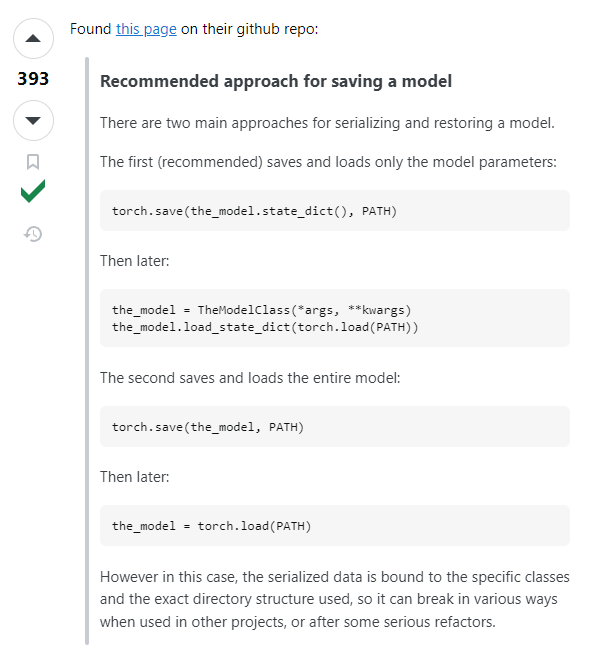

In [851]:
torch.save(model, 'model/model.pth')

In [852]:
the_model = torch.load('model/model.pth')

In [853]:
the_model(torch.Tensor([2.95,
  3.3,
  70,
  10,
  1.33e7,
  1]))

tensor([49.1698], grad_fn=<ViewBackward0>)